In [1]:
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split, TunedThresholdClassifierCV
from lightgbm import LGBMClassifier

from project_ml_course.data_process import filter_columns_by_correlation_threshold

ModuleNotFoundError: No module named 'project_ml_course'

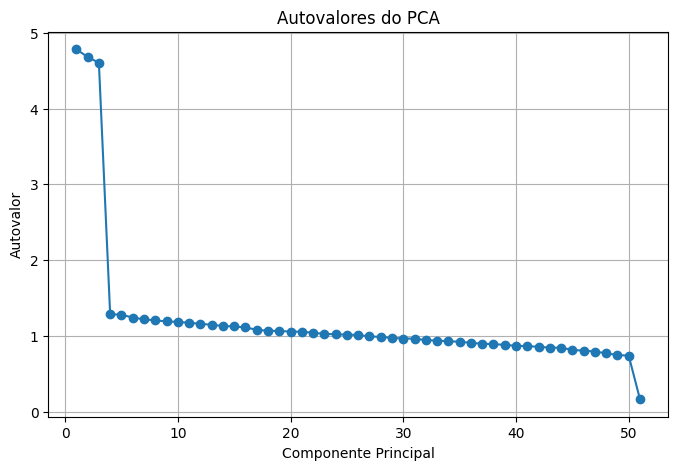

In [ ]:
raw_df = pd.read_csv("../data/dados.csv", index_col="Unnamed: 0")

df = filter_columns_by_correlation_threshold(
    df=raw_df,
    ref_col="class",
    method_type="pearson",
    lower_threshold=0.001,
    higher_threshold=0.999,
)

# Criar pipeline com StandardScaler e PCA
pipeline = Pipeline([("scaler", StandardScaler(with_std=False)), ("pca", PCA())])

# Ajustar pipeline nos dados (removendo a coluna alvo se necessário)
X = raw_df.drop(columns=["class"])
pipeline.fit(X)

# Analisar os autovalores (variância explicada)
autovalores = pipeline.named_steps["pca"].explained_variance_

# Plotar os autovalores
plt.figure(figsize=(8, 5))
plt.plot(np.arange(1, len(autovalores) + 1), autovalores, marker="o")
plt.title("Autovalores do PCA")
plt.xlabel("Componente Principal")
plt.ylabel("Autovalor")
plt.grid(True)
plt.show()

In [2]:
warnings.filterwarnings(
    "ignore",
    message="X does not have valid feature names, but LGBMClassifier was fitted with feature names",
    category=UserWarning,
    module="sklearn.utils.validation",
)

# Separar X e y
raw_df = pd.read_csv("../data/dados.csv", index_col="Unnamed: 0")
X = raw_df.drop(columns=["feat_31", "class"])
y = raw_df["class"]

# Separar treino e teste
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

f1_scores = []
n_components_range = range(1, X.shape[1] + 1)

for n_components in n_components_range:
    base_pipeline = Pipeline(
        [
            ("scaler", StandardScaler(with_std=False)),
            ("pca", PCA(n_components=n_components)),
            ("clf", LGBMClassifier(verbose=-1, random_state=42)),
        ]
    )

    model = TunedThresholdClassifierCV(
        estimator=base_pipeline,
        thresholds=np.arange(0, 1.0, 0.01),
        cv=5,
        scoring="f1",
        random_state=42,
        store_cv_results=True,
    )

    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    f1 = f1_score(y_test, y_pred)
    f1_scores.append(f1)

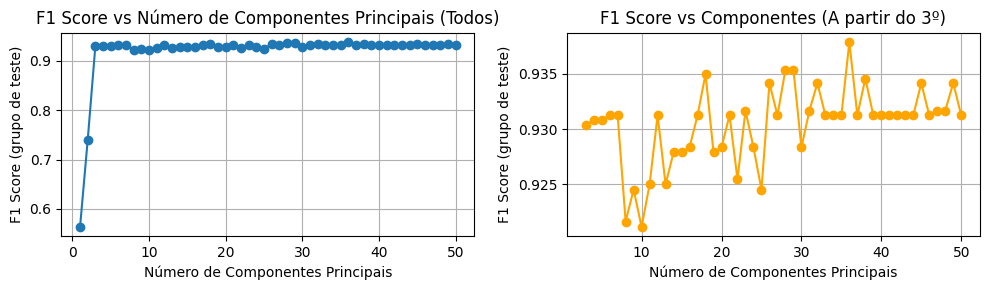

In [6]:
fig, axes = plt.subplots(1, 2, figsize=(10, 3))

# Chart 1: All components
axes[0].plot(n_components_range, f1_scores, marker="o")
axes[0].set_title("F1 Score vs Número de Componentes Principais (Todos)")
axes[0].set_xlabel("Número de Componentes Principais")
axes[0].set_ylabel("F1 Score (grupo de teste)")
axes[0].grid(True)

# Chart 2: After 3 components
axes[1].plot(n_components_range[2:], f1_scores[2:], marker="o", color="orange")
axes[1].set_title("F1 Score vs Componentes (A partir do 3º)")
axes[1].set_xlabel("Número de Componentes Principais")
axes[1].set_ylabel("F1 Score (grupo de teste)")
axes[1].grid(True)

plt.tight_layout()
plt.show()


In [8]:
# Usando StandardScaler apenas na média, PCA com 3 componentes, regressão logística, otimização do ponto de corte e cálculo do F1

# Pipeline conforme referência, mas com LogisticRegression e PCA(n_components=3)
pipe = Pipeline(
    [
        ("scaler", StandardScaler(with_std=False)),
        ("pca", PCA(n_components=3, random_state=42)),
        ("clf", LogisticRegression(random_state=42, max_iter=1000)),
    ]
)

pipe.fit(X_train, y_train)
y_proba = pipe.predict_proba(X_test)[:, 1]

# Otimização do ponto de corte para F1
thresholds = np.arange(0, 1.01, 0.01)
f1_scores = [f1_score(y_test, y_proba >= t) for t in thresholds]
best_idx = np.argmax(f1_scores)
best_threshold = thresholds[best_idx]
best_f1 = f1_scores[best_idx]

print(f"Melhor ponto de corte: {best_threshold:.2f}")
print(f"Melhor F1 score: {best_f1:.4f}")


Melhor ponto de corte: 0.37
Melhor F1 score: 0.5657


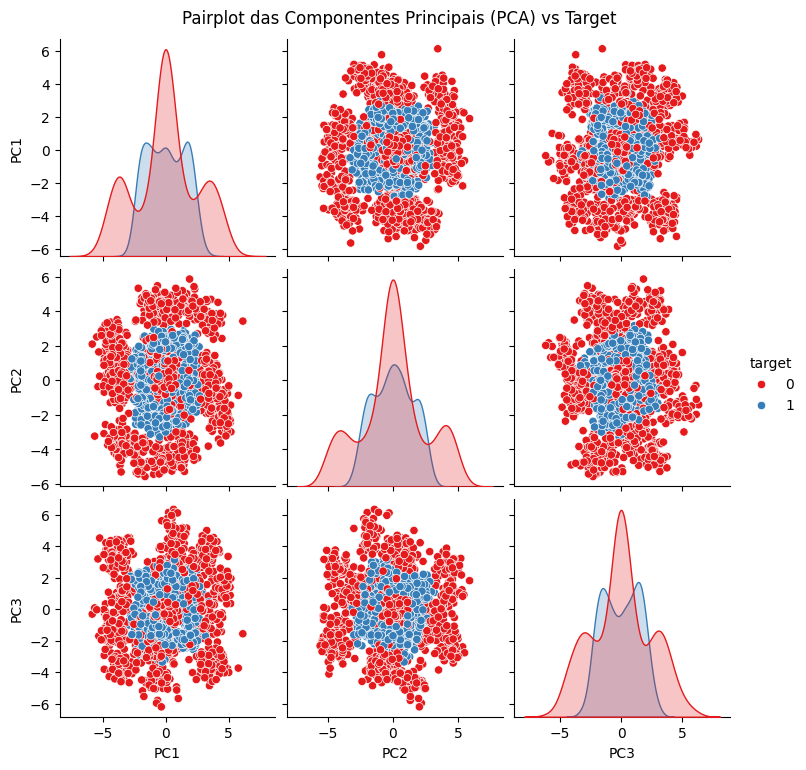

In [9]:
# Aplica scaler e PCA ao X_train e X_test, mas concatena para EDA
scaler = StandardScaler(with_std=False)
X_scaled = scaler.fit_transform(X)
pca = PCA(n_components=3, random_state=42)
X_pca = pca.fit_transform(X_scaled)

# Cria DataFrame com componentes principais e target
df_pca = pd.DataFrame(X_pca, columns=["PC1", "PC2", "PC3"])
df_pca["target"] = y.values if hasattr(y, "values") else y

# EDA: pairplot das componentes principais colorido pelo target
sns.pairplot(df_pca, hue="target", diag_kind="kde", palette="Set1")
plt.suptitle("Pairplot das Componentes Principais (PCA) vs Target", y=1.02)
plt.show()